# Vizualizing the predictions


In [1]:
import numpy as np
import dask.array as da
import xarray as xr
import zarr

from os import path

import matplotlib.pyplot as plt

import tensorflow as tf
from keras import Input
import keras.layers as layers
from keras.callbacks import EarlyStopping

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mindthegap as mtg

2025-08-21 23:51:25.987438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-21 23:51:26.006500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-21 23:51:26.012863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 23:51:26.026543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Reload trained model
If you want to reload a specific model, use `tf.kera.models.load_model` along with the path to the model.

In [2]:
import tensorflow as tf
zarr_label="2015_3_ArabSea"
model_name="UNet_DoubleConv_mse"
model = tf.keras.models.load_model(f'models/{zarr_label}/{model_name}.keras')

### Load the processed data

In [4]:
import xarray as xr
import mindthegap as mtg
import zarr
datadir = "/home/jovyan/shared-public/mindthegap/data"
zarr_label="2015_3_ArabSea_Eli"
zarr_stdized = xr.open_zarr(f'{datadir}/{zarr_label}.zarr')
ds_cropped = mtg.crop_to_multiple(zarr_stdized, multiple=8)

## Load original data
Need for plotting.

In [5]:
import xarray as xr
zarr_ds = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
lat_min, lat_max = 5, 31
lon_min, lon_max = 42, 80

import numpy as np
zarr_ds = zarr_ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min,lon_max))  # choose long and lat
zarr_ds = mtg.crop_to_multiple(zarr_ds, multiple=8)

In [27]:
def test_loss(X_test, y_test, model, print_loss=True):
    # Prepare test dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(4)

    # Evaluate the model on the test dataset
    test_mse, test_mae = model.evaluate(test_dataset)
    if print_loss:
        print(f"Test MSE: {test_mse}")
        print(f"Test MAE: {test_mae}")
    return test_mse, test_mae

In [28]:
test_mse, test_mae = test_loss(X_test, y_test, model)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - mae: 0.0375
Test MSE: 0.010837583802640438
Test MAE: 0.03541838377714157


#### Helper functions in mindthegap
- `unstdize`: unstandardize a given image to the original distribution. Since we standardized all data before training, the predicted log(Chl-a) from the model is also standardized. We apply this function so that the predictions are more comparable to the observed and other gap-filling products.
- `compute_mae`: computes the mean absolute error between two nd-arrays with the same shape. We use this function to calculate the difference between observed and predicted, or predictions between different algorithms.
- `compute_mse`: similar to `compute_mae`, but calculates the mean squared error instead.

## Plot predictions
- `plot_prediction_observed`: predicts the observed log(chl-a) data of a given date. Plots a four-panel plot with the top left being the log observed data, top right being the flag, bottom left being the log prediction, and bottom right being the log difference. Log difference shows the percentage difference: blue/log(1) means the observed is about 2.7 times the prediction, red/log(-1) means the observed is about 37% of the prediction.

2025-08-21 23:38:51.549909: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


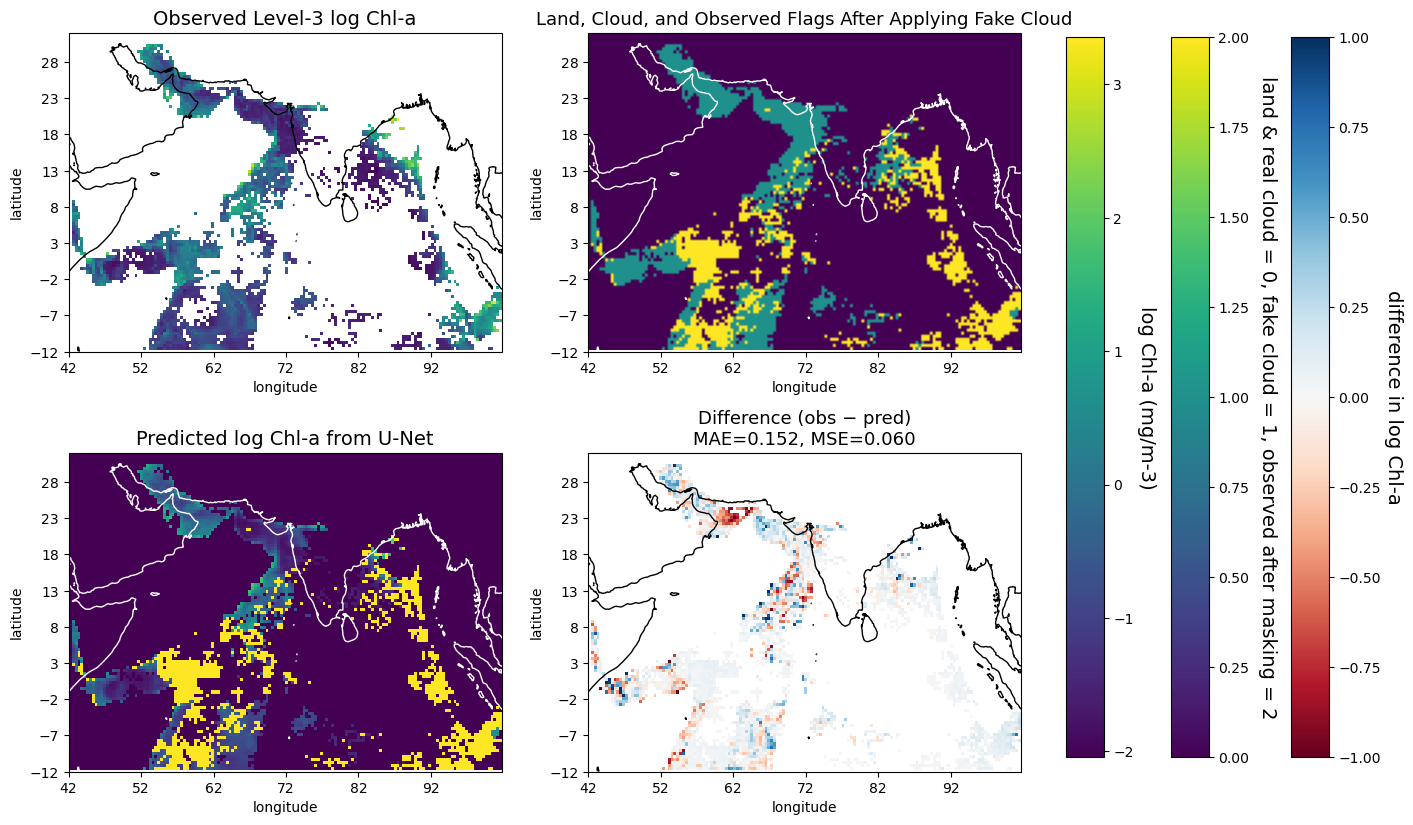

In [6]:
from mindthegap import viz
date = '2020-09-08'
viz.plot_prediction_observed(
    ds_cropped, zarr_ds, zarr_label, model, date,
    datadir=datadir)

- `plot_prediction_gapfill`:  predicts the gapfilled log(chl-a) of a given date. Plots a four-panel plot with the top left being the log gapfilled data from Copernicus GlobColour gapfree product, top right being the log U-Net prediction, bottom left being the log difference, and bottom right being the absolute difference.

2025-08-21 23:53:10.662687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


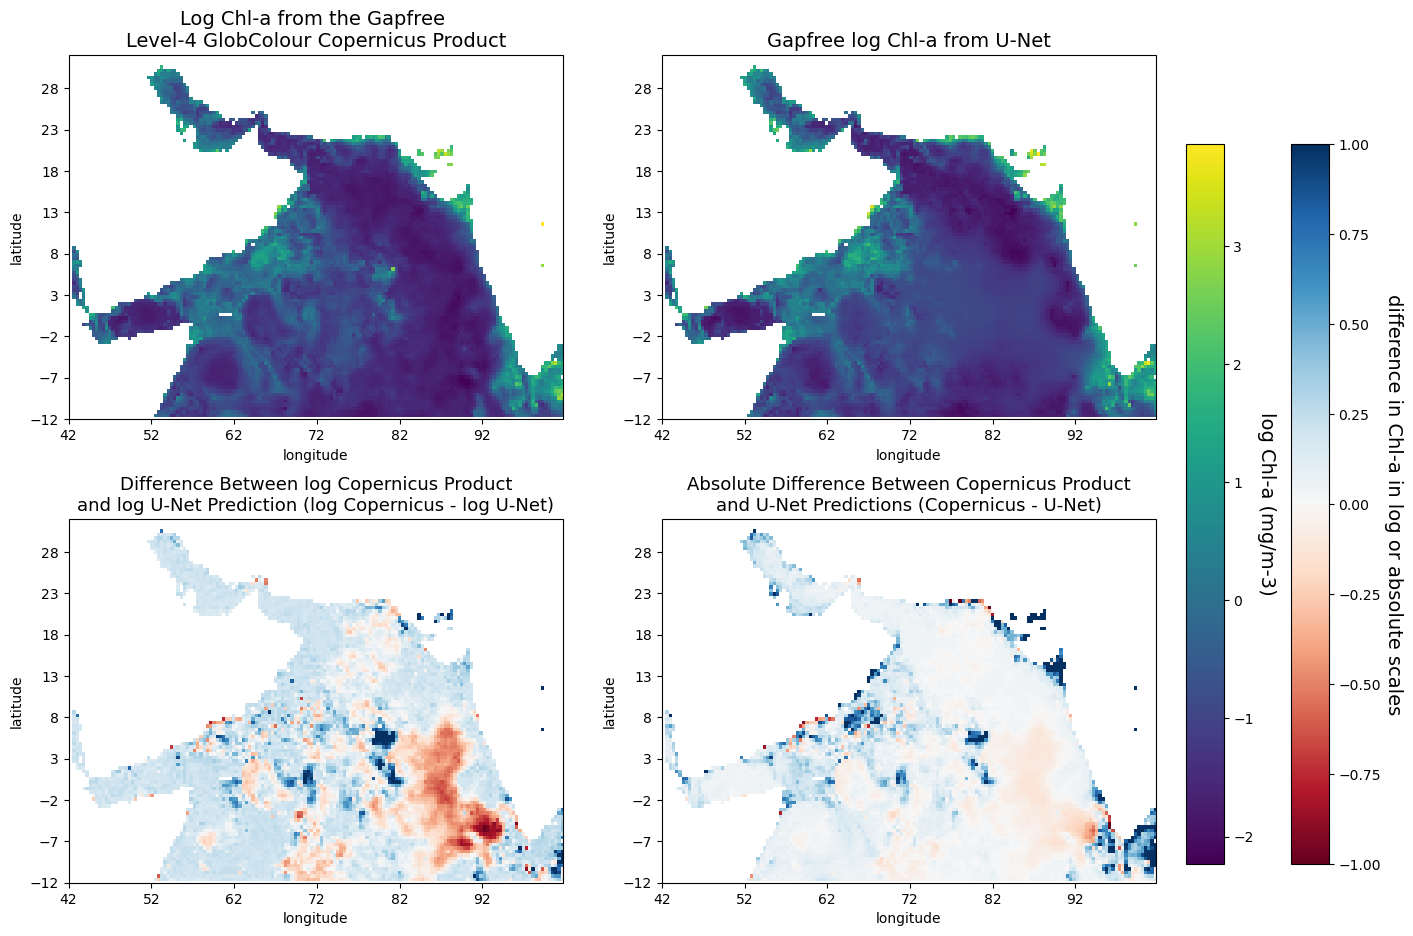

In [9]:
from mindthegap import viz
date = '2020-09-08'
viz.plot_prediction_gapfill(
    ds_cropped, 
    zarr_ds, 
    zarr_label, 
    model, 
    date,
    datadir=datadir
)

#### Plot Year-round Mean Absolute Difference
Such plots help evaluate the performance of the model on a daily basis and visualize seasonal trends.
- `yearly_MAD`: plots a line plot of the daily MAD between the observed and the U-Net prediction of the observed in a given year. 

In [14]:
def yearly_MAD(zarr_stdized, zarr_label, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')
    zarr_time_range = zarr_stdized.sel(time=time_range)

    mae = []

    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    fake_cloud_flag = zarr_time_range.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    predicted_CHL = np.where(fake_cloud_flag == 0, np.nan, predicted_CHL)
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l3) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Observed (Level-3) CHL vs U-Net Predictions Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


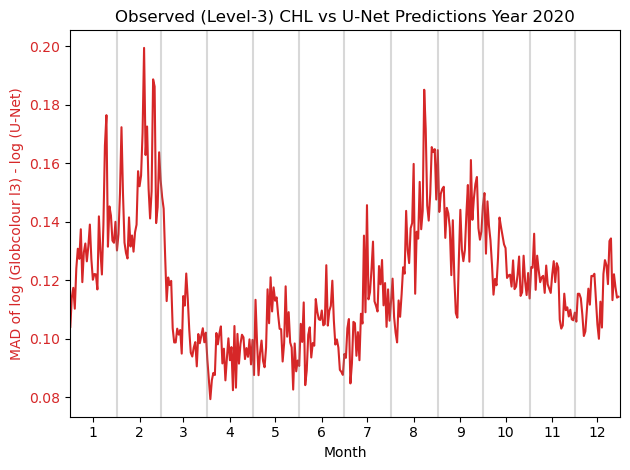

In [22]:
yearly_MAD(zarr_stdized, zarr_label, 2020)

- `yearly_MAD_vs_cloud`: plots a line plot with two lines: the red line is the daily MAD between the Copernicus Gapfree product and the U-Net's gapfree prediction in a given year, and the blue line is the daily percentage of cloud/missing data of the same year.
- `get_cloud_perc`: a helper function that gets the cloud percentage in a given year.|

In [23]:
def get_cloud_perc(zarr_stdized, year):
    zarr_time_range = zarr_stdized.sel(time=str(year))

    non_land_cnt = len(np.where(zarr_time_range['land_flag'][0] == 0)[0])
    clouds = zarr_time_range['real_cloud_flag'].data
    cloud_cnt = np.sum(clouds == 1, axis=(1, 2)).compute()
    cloud_perc = cloud_cnt / non_land_cnt

    return cloud_perc
    

def yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, year):
    mean_std = np.load(f'{datadir}/{zarr_label}.npy',allow_pickle='TRUE').item()
    mean, std = mean_std['CHL'][0], mean_std['CHL'][1]
    time_range = slice(f'{year}-01-01', f'{year}-12-31')

    zarr_time_range = zarr_stdized.sel(time=time_range)
    
    X = []
    X_vars = list(zarr_stdized.keys())
    X_vars.remove('CHL')
    X_vars[X_vars.index('masked_CHL')] = 'CHL'
    X_vars[X_vars.index('real_cloud_flag')] = 'a'
    X_vars[X_vars.index('fake_cloud_flag')] = 'real_cloud_flag'
    X_vars[X_vars.index('a')] = 'fake_cloud_flag'
    for var in X_vars:
        var = zarr_time_range[var].to_numpy()
        X.append(np.where(np.isnan(var), 0.0, var))
    valid_CHL_ind = X_vars.index('valid_CHL_flag')
    X[valid_CHL_ind] = da.where(X[X_vars.index('fake_cloud_flag')] == 1, 1, X[valid_CHL_ind]) 
    X[X_vars.index('fake_cloud_flag')] = np.zeros(X[0].shape)
    X_masked_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-level3'].to_numpy())
    X_masked_CHL = (X_masked_CHL - da.full(X_masked_CHL.shape, mean_std['masked_CHL'][0])) / da.full(X_masked_CHL.shape, mean_std['masked_CHL'][1])
    X_vars[X_vars.index('CHL')] = da.where(da.isnan(X_masked_CHL), 0.0, X_masked_CHL)
    X = np.array(X)
    X = np.moveaxis(X, 0, -1)

    true_CHL = np.log(zarr_ds.sel(time=time_range)['CHL_cmes-gapfree'].to_numpy())            
    # fake_cloud_flag = zarr_date.fake_cloud_flag.to_numpy()
    predicted_CHL = model.predict(X, verbose=0)
    predicted_CHL = predicted_CHL.reshape(predicted_CHL.shape[:-1])
    predicted_CHL = unstdize(predicted_CHL, mean, std)
    flag = zarr_ds.sel(time=str(year))['CHL_cmes-level3'].to_numpy()
    predicted_CHL = np.where(~np.isnan(flag), np.nan, predicted_CHL)
    mae = []
    for true, pred in zip(true_CHL, predicted_CHL):
        mae.append(compute_mae(true, pred))
    
    cloud_perc = get_cloud_perc(zarr_stdized, year)
    
    fig, ax1 = plt.subplots()
    
    color = 'tab:red'
    ax1.set_xlabel('Month')
    ax1.set_ylabel('MAD of log (Globcolour l4) - log (U-Net)', color=color)
    ax1.plot(mae, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cloud Percentage', color=color)  # we already handled the x-label with ax1
    ax2.plot(cloud_perc, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    tick_pos = []
    tick_label = []
    total_day = 1
    tick_pos.append(total_day + 15)
    tick_label.append('1')
    for month in range(1, 12):
        total_day += calendar.monthrange(year, month)[1]
        plt.axvline(total_day, color='grey', alpha=0.3)
        tick_pos.append(total_day + 15)
        tick_label.append(str(month+1))
    plt.title(f'Copernicus GlobColour Gapfree CHL vs U-Net Predictions\nMAD vs Cloud Percentage Year {year}')
    plt.xlim(1, len(mae))
    plt.xticks(tick_pos, tick_label)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

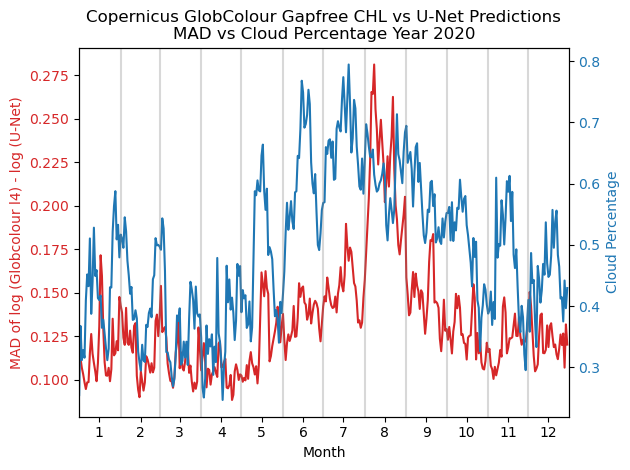

In [24]:
yearly_MAD_vs_cloud(zarr_stdized, zarr_label, model, 2020)